In [1]:
import os
import sys
from pathlib import Path
import torch
import numpy as np
from scipy.stats import binom
from scipy.special import comb, gamma, kv
from functools import partial
import pandas as pd
import seaborn as sns

if os.path.abspath('..') not in sys.path:
    sys.path.insert(0, os.path.abspath('..'))

device = "cuda:0" if torch.cuda.is_available() else None

sns.set(font_scale=1.25, style='whitegrid', palette=sns.color_palette("Set1"))

In [2]:
from torch.utils.cpp_extension import load

module_root = Path(os.path.abspath('')) / '..' / 'bi_gp'

def lazy_compile(is_cuda):
    if is_cuda:
        return load(name="gpu_lattice", verbose=True,
            sources=[
                module_root / 'cuda' / 'permutohedral_cuda.cpp',
                module_root / 'cuda' / 'permutohedral_cuda_kernel.cu'
            ]).filter
    else:
        return load(name="cpu_lattice", verbose=True,
            sources=[
                module_root / 'lattice.cpp'
            ]).filter

latticefilter = lazy_compile(torch.cuda.is_available())

Using /home/sanyam_s/.cache/torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/sanyam_s/.cache/torch_extensions/gpu_lattice/build.ninja...
Building extension module gpu_lattice...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module gpu_lattice...


In [3]:
def gaussian_normalization(ell):
    # Integral of Gaussian covariance with lengthscale ell from 0 to infinity
    return np.sqrt(2 * np.pi * ell**2)

def matern_normalization(ell, nu):
    # Integral of Matern covariance with lengthscale ell from 0 to infinity
    return np.sqrt(2 * np.pi * ell**2) * gamma(nu + 0.5)/gamma(nu)/(nu**0.5)

def gaussian_covariance(tau, ell=1.):
    tau_norm = tau / ell
    return np.exp(-tau_norm**2/2)/gaussian_normalization(ell)

def matern_covariance(tau, ell=1., nu=0.5):
    if np.isinf(nu): return gaussian_covariance(tau, ell=ell)
    # Matern covariance with lengthscale ell    
    tau[tau == 0.0] += np.finfo(float).eps  # strict zeros result in nan
    tau_norm = np.sqrt(2*nu) * np.abs(tau) / ell
    unnormalized_covar = (2**(1-nu) / gamma(nu)) * (tau_norm)**nu * kv(nu, tau_norm)
    return unnormalized_covar/matern_normalization(ell,nu)

In [4]:
def fill(xmax,order,nu=.5):
    """ computes the rectangle rule integration of matern with given spacing"""
    n = 2*order+1
    grid = np.linspace(-xmax,xmax,n)
    fx = matern_covariance(grid,nu=nu)
    dx = xmax/order
    return fx.sum()*dx
    #return np.trapz(fx,grid)

def fill2(xmax,order,nu=.5):
    """"""
    n = 2*order+1
    grid = np.linspace(-xmax,xmax,n)
    f_on_grid = matern_covariance(grid,nu=nu)
    upper = (1+.5/order)*xmax
    lower = -upper
    def discretized_fn(x):
        xbin = ((x - lower)//((upper-lower)/n)).astype(int)
        return np.where((xbin>=0)|(xbin<n),f_on_grid[xbin%n],np.zeros_like(x))
    N=10000
    finegrid = np.linspace(-10,10,N)
    ISE = ((matern_covariance(finegrid,nu=nu)-discretized_fn(finegrid))**2).mean()
    return ISE

def binary_search(target,bounds,fn,eps=1e-2):
    lb,ub = bounds
    i = 0
    while ub-lb>eps:
        guess = (ub+lb)/2
        y = fn(guess)
        if y<target:
            lb = guess
        elif y>=target:
            ub = guess
        i+=1
        if i>500: assert False
    return (ub+lb)/2

In [5]:
order=2
fn = partial(fill,order=order,nu=np.inf)
xf = binary_search(1,(.1,10),fn,1e-3)
print(xf,fn(xf))

ci = gaussian_covariance(np.linspace(-xf,xf,2*order+1))
ci = ci / ci[order]
ci

2.8514434814453127 0.9999999517959793


array([0.01715673, 0.36191669, 1.        , 0.36191669, 0.01715673])

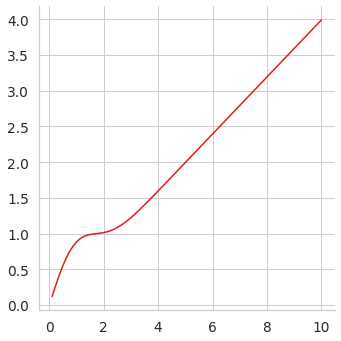

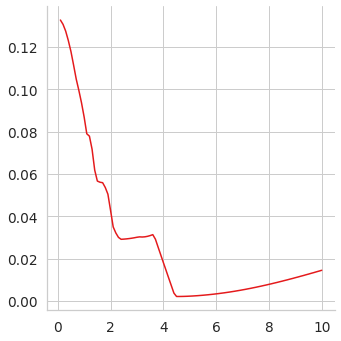

In [6]:
X = np.linspace(.1,10,100)
sns.relplot(x=X,y=[fill(x,1,nu=np.inf) for x in X],kind='line')
sns.relplot(x=X,y=[fill2(x,2,nu=np.inf) for x in X],kind='line')

In [7]:
from gpytorch.kernels import RBFKernel, MaternKernel
from bi_gp.bilateral_kernel import MaternLattice, RBFLattice

In [8]:
def rel_err(x,y):
    return ((x-y)**2).mean().sqrt()/((x**2).mean().sqrt()+(y**2).mean().sqrt())

In [9]:
dpath = 'snelson.csv'
snel = pd.read_csv(dpath)
X = torch.from_numpy(snel.x.to_numpy()).unsqueeze(-1).float().to(device)
y = torch.from_numpy(snel.y.to_numpy()).float().to(device).unsqueeze(-1)

In [22]:
with torch.no_grad():
    # K_gt = RBFKernel().to(device)
    # K_lattice = RBFLattice(order=1).to(device)

    K_gt = MaternKernel(nu=1.5).to(device)
    K_lattice = MaternLattice(nu=1.5, order=1).to(device)

    K_gt.lengthscale = K_lattice.lengthscale = .5

    mvm_gt = K_gt(X, X) @ y
    mvm_lattice = K_lattice(X, X) @ y
    e = rel_err(mvm_gt,mvm_lattice/(mvm_lattice/mvm_gt).mean())
    print(e)

Discretized kernel coeffs: tensor([0.3461, 1.0000, 0.3461])
Discretized kernel deriv coeffs: tensor([0.3461, 1.0000, 0.3461])
tensor(0.0289, device='cuda:0')
